In [14]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import *
from scipy.interpolate import CubicSpline

In [4]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install())) 

In [5]:
data_di = "05/09/2024"
mercadoria = 'DI1'

In [6]:
url = f'''
https://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?pagetype=pop&caminho=Resumo%20
Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={data_di}&Mercadoria={mercadoria}
'''

driver.get(url)

driver.implicitly_wait(3)

'''
esse método de congelar é MUITO mais eficiente que o time, porque ele só espera o tempo necessário.
se o elemento que você quer achar já carregou, ele roda e acabou. 
'''

driver.maximize_window()

#driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options = options) 


local_tabela = '''
/html/body/div/div[2]/form[1]/table[3]/tbody/tr[3]/td[3]/table
'''

local_indice = '''
/html/body/div/div[2]/form[1]/table[3]/tbody/tr[3]/td[1]/table
'''

elemento = driver.find_element("xpath", local_tabela)


elemento_indice = driver.find_element("xpath", local_indice)

html_tabela = elemento.get_attribute('outerHTML')
html_indice = elemento_indice.get_attribute('outerHTML')

tabela = pd.read_html(html_tabela)[0]
indice = pd.read_html(html_indice)[0]

driver.quit()

tabela.columns = tabela.loc[0]

tabela = tabela['ÚLT. PREÇO']

tabela = tabela.drop(0, axis = 0)

indice.columns = indice.loc[0]

indice_di = indice['VENCTO']

indice = indice.drop(0, axis = 0)

tabela.index = indice['VENCTO']

tabela = tabela.astype(int)

tabela = tabela[tabela != 0]

tabela = tabela/1000

legenda = pd.Series(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    index = ['F', 'G', 'H', 'J', 'K', 'M', 'N', 'Q', 'U', 'V', 'X', 'Z'])

lista_datas = []

for indice in tabela.index:

    letra = indice[0]
    
    legenda["F"]
    ano = indice[1:3]

    mes = legenda[letra]

    data = f"{mes}-{ano}"

    data = datetime.strptime(data, "%b-%y")

    lista_datas.append(data)


tabela.index = lista_datas  

tabela

print(tabela)

2024-10-01    10.514
2024-11-01    10.602
2024-12-01    10.730
2025-01-01    10.905
2025-02-01    11.065
2025-03-01    11.180
2025-04-01    11.280
2025-05-01    11.350
2025-06-01    11.440
2025-07-01    11.495
2025-08-01    11.535
2025-09-01    11.585
2025-10-01    11.625
2026-01-01    11.665
2026-04-01    11.705
2026-07-01    11.695
2026-10-01    11.685
2027-01-01    11.650
2027-04-01    11.670
2027-07-01    11.700
2027-10-01    11.710
2028-01-01    11.720
2028-04-01    11.750
2028-07-01    11.780
2028-10-01    11.785
2029-01-01    11.795
2029-04-01    11.805
2029-07-01    11.805
2030-01-01    11.820
2031-01-01    11.790
2032-01-01    11.760
2033-01-01    11.760
2034-01-01    11.710
2035-01-01    11.730
Name: ÚLT. PREÇO, dtype: float64


# Interpolação

Vamos esse cenário:

Hoje é dia 06/09/2024.
Essa é a curva de juros.
Qual é o DI de 18/04 de 2028?

In [7]:
curva_dias_uteis = []
dia_atual = datetime(2024, 9, 5)

for dia in tabela.index:
    
    dias_uteis = len(pd.date_range(dia_atual, dia, freq=BDay()))
    
    curva_dias_uteis.append(dias_uteis)
    
curva_dias_uteis

[19,
 42,
 62,
 85,
 107,
 127,
 149,
 171,
 192,
 214,
 237,
 258,
 280,
 346,
 410,
 475,
 541,
 607,
 671,
 736,
 802,
 867,
 932,
 997,
 1062,
 1128,
 1192,
 1257,
 1389,
 1650,
 1911,
 2172,
 2432,
 2693]

In [8]:
taxas = tabela.values

taxas = list(taxas)

taxas

[10.514,
 10.602,
 10.73,
 10.905,
 11.065,
 11.18,
 11.28,
 11.35,
 11.44,
 11.495,
 11.535,
 11.585,
 11.625,
 11.665,
 11.705,
 11.695,
 11.685,
 11.65,
 11.67,
 11.7,
 11.71,
 11.72,
 11.75,
 11.78,
 11.785,
 11.795,
 11.805,
 11.805,
 11.82,
 11.79,
 11.76,
 11.76,
 11.71,
 11.73]

In [9]:
len(curva_dias_uteis)

34

In [11]:
dias_uteis_daqui_pra_data = len(pd.date_range(dia_atual, datetime(2028, 4, 18), freq=BDay()))

dias_uteis_daqui_pra_data

944

In [12]:
from scipy import interpolate
import mplcyberpunk
import matplotlib.pyplot as plt

plt.style.use("cyberpunk")

In [15]:
linear = interpolate.interp1d(curva_dias_uteis, taxas, kind = 'linear')
cubica = interpolate.interp1d(curva_dias_uteis, taxas, kind = 'cubic')
splines_cubicas = CubicSpline(curva_dias_uteis, taxas, bc_type='natural')

In [16]:
dias_novos = [dias_uteis_daqui_pra_data, 520, 385, 2200]
taxas_linear = list(linear(dias_novos))
taxas_cubica = list(cubica(dias_novos))
taxas_splines_cubica = list(splines_cubicas(dias_novos))

In [17]:
taxas_linear

[11.755538461538462, 11.68818181818182, 11.689375, 11.754615384615384]

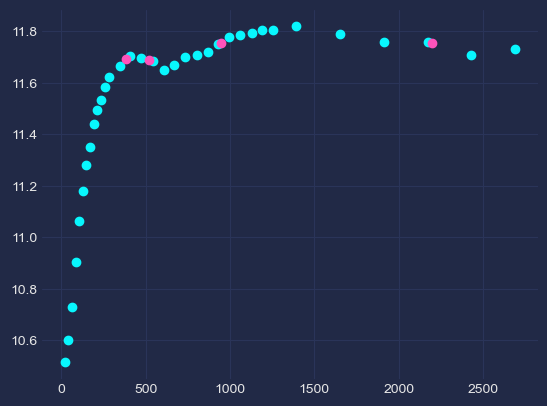

In [18]:
fig, ax = plt.subplots()

ax.scatter(curva_dias_uteis, taxas)
#ax.scatter(dias_novos, taxas_linear)
#ax.scatter(dias_novos, taxas_cubica)
ax.scatter(dias_novos, taxas_splines_cubica)